In [1]:
# Importing necessary modules
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

2023-07-04 19:32:13.886485: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-04 19:32:13.929634: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-04 19:32:13.930411: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-04 19:32:14.578910: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

# Removing the sale price column from training data to process training and testing data together
df_final_train = pd.DataFrame({'SalePrice':df_train['SalePrice']})
df_train = df_train.drop('SalePrice', axis = 1)

# Creating a combined dataframe
df_combined = pd.concat([df_train, df_test], axis=0)

df_train.shape, df_test.shape, df_combined.shape, df_final_train.shape

((1460, 80), (1459, 80), (2919, 80), (1460, 1))

In [3]:
# Removing ID column
df_combined = df_combined.drop('Id', axis = 1)

df_combined.shape

(2919, 79)

In [4]:
# Checking for null values
percent_na_columns = df_combined.isnull().mean()

# Finding the column names of those having missing values greater than 10%
missing_columns = percent_na_columns[percent_na_columns>0.1].index

df_combined = df_combined.drop(missing_columns, axis = 1)

df_combined.shape

(2919, 72)

In [5]:
# Filling categorical missing data with mode for columns having less null values
categorical_columns = df_combined.select_dtypes(include=['object', 'category']).columns

na_sum = df_combined[categorical_columns].isnull().sum()
columns_below_threshold = na_sum[na_sum < 20].index
columns_above_threshold = pd.Series(na_sum[na_sum >= 20].index)

df_combined[columns_below_threshold] = df_combined[columns_below_threshold].fillna(df_combined[columns_below_threshold].mode().iloc[0])

# Filling non-categorical missing data with mean for columns having less null values
numerical_columns = df_combined.select_dtypes(include=['int', 'float']).columns

na_sum = df_combined[numerical_columns].isnull().sum()
num_columns_below_threshold = na_sum[na_sum < 20].index
num_columns_above_threshold = pd.Series(na_sum[na_sum >= 20].index)

df_combined[num_columns_below_threshold] = df_combined[num_columns_below_threshold].fillna(df_combined[num_columns_below_threshold].mean().iloc[0])

above_threshold = pd.Index(pd.concat([columns_above_threshold, num_columns_above_threshold], axis = 0))

In [6]:
# Filling all else data using k nearest neighbours
df_encoded = df_combined.copy()

encoder = LabelEncoder()
for col in categorical_columns:
    df_encoded[col] = encoder.fit_transform(df_combined[col].astype(str))
    
imputer = KNNImputer(n_neighbors = 3)

df_combined = pd.DataFrame(imputer.fit_transform(df_encoded), columns=df_encoded.columns)

for col in categorical_columns:
    df_combined[col] = df_combined[col].astype(int).astype('category').cat.categories[df_combined[col].astype(int)]

df_combined.head()

,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60.0,3,8450.0,1,3,3,0,4,0,5,...,61.0,0.0,0.0,0.0,0.0,0.0,2.0,2008.0,8,4
1,20.0,3,9600.0,1,3,3,0,2,0,24,...,0.0,0.0,0.0,0.0,0.0,0.0,5.0,2007.0,8,4
2,60.0,3,11250.0,1,0,3,0,4,0,5,...,42.0,0.0,0.0,0.0,0.0,0.0,9.0,2008.0,8,4
3,70.0,3,9550.0,1,0,3,0,0,0,6,...,35.0,272.0,0.0,0.0,0.0,0.0,2.0,2006.0,8,0
4,60.0,3,14260.0,1,0,3,0,2,0,15,...,84.0,0.0,0.0,0.0,0.0,0.0,12.0,2008.0,8,4


In [7]:
# OneHotEncoding categorical columns and normalising data from numerical columns
df_combined = pd.get_dummies(df_combined, columns=categorical_columns)

df_combined[numerical_columns] = np.log1p(df_combined[numerical_columns])
df_combined[numerical_columns] = (df_combined[numerical_columns] - df_combined[numerical_columns].mean()) / (df_combined[numerical_columns].std())

In [8]:
similarity_threshold = 1
similar_columns = []

similar_columns = []
for i in range(df_combined.shape[1]):
    for j in range(i+1, df_combined.shape[1]):
        similarity = np.mean(df_combined.iloc[:, i] == df_combined.iloc[:, j])
        if similarity >= similarity_threshold:
            similar_columns.append(df_combined.columns[j])

similar_columns = set(similar_columns)

df_combined = df_combined.drop(similar_columns, axis =1)

In [9]:
df_train = df_combined.loc[:1459]
df_test_final = df_combined.loc[1460:]

df_final_train = pd.concat([df_train, df_final_train], axis = 1)

df_final_train.shape, df_test_final.shape

((1460, 273), (1459, 272))

In [10]:
train_data = df_final_train.copy()
submission_data = df_test_final.copy()

# Shuffling the data 
train_data = train_data.sample(frac = 1)

# Convering values into numpy arrays
y = (train_data['SalePrice']).values
train_data = train_data.drop(columns='SalePrice', axis = 1)
x = train_data.values

submission = submission_data.values

x = x.astype('float')
y = y.astype('float')
submission = submission.astype('float')

y = np.log(y)

train_data.shape

(1460, 272)

In [11]:
input_dim = x.shape[1]

# Creating autoencoder
encoder_input = tf.keras.Input(shape=input_dim)
encoder_hidden_1 = tf.keras.layers.Dense(20, activation='relu')(encoder_input)

decoder_output = tf.keras.layers.Dense(input_dim, activation='sigmoid')(encoder_hidden_1)

autoencoder = tf.keras.Model(encoder_input, decoder_output)

# Creating neural network
neural_network_input = tf.keras.Input(shape=input_dim)
neural_network_hidden1 = tf.keras.layers.Dense(20, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.01))(neural_network_input)
neural_network_hidden2 = tf.keras.layers.Dense(10, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.01))(neural_network_hidden1)
neural_network_output = tf.keras.layers.Dense(1)(neural_network_hidden2)

model = tf.keras.Model(neural_network_input, neural_network_output)

autoencoder.summary(), model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 272)]             0         
                                                                 
 dense (Dense)               (None, 20)                5460      
                                                                 
 dense_1 (Dense)             (None, 272)               5712      
                                                                 
Total params: 11,172
Trainable params: 11,172
Non-trainable params: 0
_________________________________________________________________
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 272)]             0         
                                                                 
 dense_2 (Dense)             (None, 20) 

(None, None)

In [12]:
def rmse(y_true, y_pred):
    loss = tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))
    return loss

In [13]:
# autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
# model.compile(optimizer='adam', loss=rmse, metrics=['mape'])

# autoencoder.fit(x, x, epochs = 100, validation_split=0.2)

# x_autoencoded = autoencoder.predict(x)

# model.fit(x_autoencoded, y, epochs = 1000, validation_split=0.2)

In [14]:
model.compile(optimizer='adam', loss=rmse)
model.fit(x, y, epochs = 1250, validation_split=0.2)

Epoch 1/1250
37/37 [==============================] - 1s 6ms/step - loss: 14.1446 - val_loss: 11.3093
Epoch 2/1250
37/37 [==============================] - 0s 3ms/step - loss: 7.5832 - val_loss: 3.1608
Epoch 3/1250
37/37 [==============================] - 0s 3ms/step - loss: 2.7374 - val_loss: 2.1785
Epoch 4/1250
37/37 [==============================] - 0s 3ms/step - loss: 1.9655 - val_loss: 1.8004
Epoch 5/1250
37/37 [==============================] - 0s 3ms/step - loss: 1.6717 - val_loss: 1.6216
Epoch 6/1250
37/37 [==============================] - 0s 2ms/step - loss: 1.5134 - val_loss: 1.5102
Epoch 7/1250
37/37 [==============================] - 0s 3ms/step - loss: 1.3992 - val_loss: 1.4061
Epoch 8/1250
37/37 [==============================] - 0s 2ms/step - loss: 1.3023 - val_loss: 1.3212
Epoch 9/1250
37/37 [==============================] - 0s 2ms/step - loss: 1.2313 - val_loss: 1.2571
Epoch 10/1250
37/37 [==============================] - 0s 3ms/step - loss: 1.1708 - val_loss: 1.21

46/46 [==============================] - 0s 2ms/step


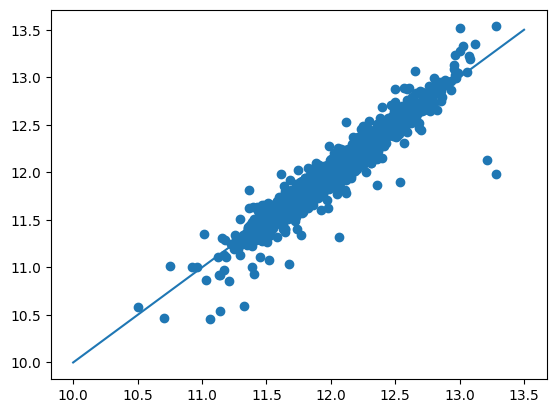

In [15]:
y_pred = model.predict(x)

n=np.linspace(10, 13.5, 100)

plt.scatter(y_pred, y)
plt.plot(n, n)

In [16]:
y_pred = model.predict(submission)
y_pred = np.exp(y_pred)
y_pred = y_pred.reshape(-1)

n = np.linspace(1461, 2919, 1459, dtype='int')

df = pd.DataFrame({'Id':n, 'SalePrice':y_pred})

# df.to_csv('submission.csv', index=False)

46/46 [==============================] - 0s 1ms/step
